# Threshold & GMM Analysis

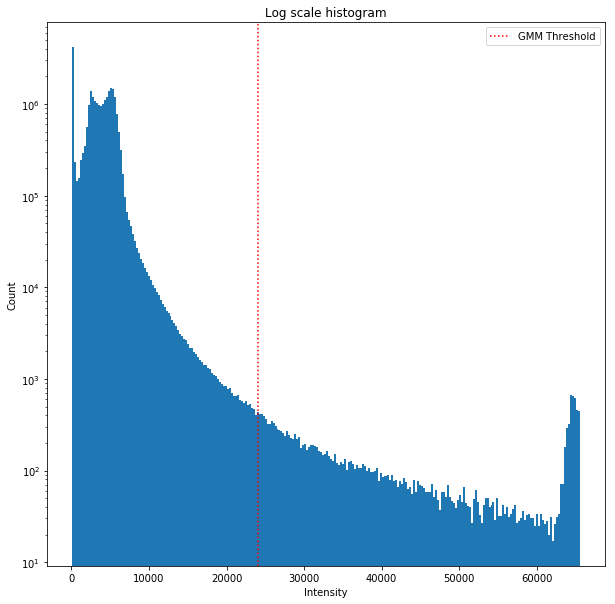

In [46]:
%reload_ext autoreload
%autoreload 2
from IPython.core.pylabtools import figsize
figsize(10, 10)

from tifffile import imread, imsave
from src.BlobDetector import BlobDetector
from src import util
import matplotlib.pyplot as plt
import numpy as np

exp_name = 'cell_detection_9'
data_source = 'COLM' if int(exp_name.split('_')[2]) <= 3 else 'laVision'

input_tif_path = './data/s3617/tifs/{}.tiff'.format(exp_name)

img = imread(input_tif_path)

detector = BlobDetector(input_tif_path, data_source=data_source)
centroids = detector.get_blob_centroids()

plt.hist(img.flatten(), bins=256, log=True)
plt.axvline(x=detector.threshold, linestyle='dotted', color='r', label='GMM Threshold')


plt.title('Log scale histogram')
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.legend()
plt.show()